<a href="https://colab.research.google.com/github/begraiPB/Data255DeepLearning/blob/main/Demo%20-%20Assignment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the code provided in demo 02 to complete this assignment.

Step 1. Follow along with the tutorial to gain an understanding of the process

Step 2. In a new .ipynb notebook, reproduce the results utilizing the "QMNIST" dataset

Step 3. Report on the results in terms of prediction accuracy on the train and test datasets

Step 4. Choose one of the proposed modifications below:

Add another Dense layer of 128 nodes Increase the current number of nodes in the layer to 256 Hypothesize how it would change the performance results

Step 5. Modify the model based on the chosen method and train

Step 6. Report on the results of the modified model and if it matches your hypothesis

Step 7. Experiment with different optimizers, loss functions, dropout, and activation functions, and observe the change in performance as you tune these hyperparameters.

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Text classification with the torchtext library

In this tutorial, we will show how to use the torchtext library to build the dataset for the text classification analysis. Users will have the flexibility to

   - Access to the raw data as an iterator
   - Build data processing pipeline to convert the raw text strings into ``torch.Tensor`` that can be used to train the model
   - Shuffle and iterate the data with [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)_


## Prerequisites

A recent 2.x version of the ``portalocker`` package needs to be installed prior to running the tutorial.
For example, in the Colab environment, this can be done by adding the following line at the top of the script:

.. code-block:: bash
     
    !pip install -U portalocker>=2.0.0`


In [ ]:
!pip install -U portalocker>=2.0.0

### Access to the raw dataset iterators

The torchtext library provides a few raw dataset iterators, which yield the raw text strings. For example, the ``AG_NEWS`` dataset iterators yield the raw data as a tuple of label and text.

To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data.




In [ ]:
!pip install torchdata
!pip install torchtext

In [ ]:
import torch
import portalocker
from torchtext.datasets import AG_NEWS

train_iter = iter(AG_NEWS(split="train"))

In [ ]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

```sh
next(train_iter)
>>> (3, "Fears for T N pension after talks Unions representing workers at Turner
Newall say they are 'disappointed' after talks with stricken parent firm Federal
Mogul.")

next(train_iter)
>>> (4, "The Race is On: Second Private Team Sets Launch Date for Human
Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\\team of
rocketeers competing for the  #36;10 million Ansari X Prize, a contest
for\\privately funded suborbital space flight, has officially announced
the first\\launch date for its manned rocket.")

next(train_iter)
>>> (4, 'Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded
by a chemistry researcher at the University of Louisville won a grant to develop
a method of producing better peptides, which are short chains of amino acids, the
building blocks of proteins.')
```


### Prepare data processing pipelines

We have revisited the very basic components of the torchtext library, including vocab, word vectors, tokenizer. Those are the basic data processing building blocks for raw text string.

Here is an example for typical NLP data processing with tokenizer and vocabulary. The first step is to build a vocabulary with the raw training dataset. Here we use built in
factory function `build_vocab_from_iterator` which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the
vocabulary.



In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

The vocabulary block converts a list of tokens into integers.

```sh
vocab(['here', 'is', 'an', 'example'])
>>> [475, 21, 30, 5297]
```
Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.



In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers. For example,

```sh
text_pipeline('here is the an example')
>>> [475, 21, 2, 30, 5297]
label_pipeline('10')
>>> 9
```


### Generate data batch and iterator

[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)_
is recommended for PyTorch users (a tutorial is [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)_).
It works with a map-style dataset that implements the ``getitem()`` and ``len()`` protocols, and represents a map from indices/keys to data samples. It also works with an iterable dataset with the shuffle argument of ``False``.

Before sending to the model, ``collate_fn`` function works on a batch of samples generated from ``DataLoader``. The input to ``collate_fn`` is a batch of data with the batch size in ``DataLoader``, and ``collate_fn`` processes them according to the data processing pipelines declared previously. Pay attention here and make sure that ``collate_fn`` is declared as a top level def. This ensures that the function is available in each worker.

In this example, the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of ``nn.EmbeddingBag``. The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of individual text entries.



In [ ]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_iter = AG_NEWS(split="train")
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)

### Define the model

The model is composed of the [nn.EmbeddingBag](https://pytorch.org/docs/stable/nn.html?highlight=embeddingbag#torch.nn.EmbeddingBag)_ layer plus a linear layer for the classification purpose. ``nn.EmbeddingBag`` with the default mode of "mean" computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, ``nn.EmbeddingBag`` module requires no padding here since the text lengths are saved in offsets.

Additionally, since ``nn.EmbeddingBag`` accumulates the average across
the embeddings on the fly, ``nn.EmbeddingBag`` can enhance the
performance and memory efficiency to process a sequence of tensors.

<img src="file://../_static/img/text_sentiment_ngrams_model.png">




In [ ]:
from torch import nn


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Initiate an instance

The ``AG_NEWS`` dataset has four labels and therefore the number of classes is four.

```sh
1 : World
2 : Sports
3 : Business
4 : Sci/Tec
```
We build a model with the embedding dimension of 64. The vocab size is equal to the length of the vocabulary instance. The number of classes is equal to the number of labels,




In [ ]:
train_iter = AG_NEWS(split="train")
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
vocab_size

95811

### Define functions to train the model and evaluate results.




In [ ]:
import time


def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

### Split the dataset and run the model

Since the original ``AG_NEWS`` has no valid dataset, we split the training
dataset into train/valid sets with a split ratio of 0.95 (train) and
0.05 (valid). Here we use
[torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split)_
function in PyTorch core library.

[CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)_
criterion combines ``nn.LogSoftmax()`` and ``nn.NLLLoss()`` in a single class.
It is useful when training a classification problem with C classes.
[SGD](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html)_
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0.
[StepLR](https://pytorch.org/docs/master/_modules/torch/optim/lr_scheduler.html#StepLR)_
is used here to adjust the learning rate through epochs.




In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


| epoch   1 |   500/ 1782 batches | accuracy    0.686
| epoch   1 |  1000/ 1782 batches | accuracy    0.857
| epoch   1 |  1500/ 1782 batches | accuracy    0.875
-----------------------------------------------------------
| end of epoch   1 | time: 36.98s | valid accuracy    0.889 
-----------------------------------------------------------


KeyboardInterrupt: 

### Evaluate the model with test dataset




Checking the results of the test dataset…



In [ ]:
print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.885


### Test on a random news

Use the best model so far and test a golf news.




In [ ]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}


def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


# Basic classification: Classify images of clothing

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete Pytorch program with the details explained as you go.

Import the Fashion MNIST dataset
This guide uses the Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels).

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from Pytorch.

In [ ]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Loading the dataset returns four NumPy arrays:

The train_images and train_labels arrays are the training set—the data the model uses to learn.
The model is tested against the test set, the test_images, and test_labels arrays.
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

```
Label	Class
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
```

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [ ]:
# Load Fashion MNIST dataset and preprocess
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 12826936.57it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 233036.19it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4270923.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14748823.08it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Iterating and Visualizing the Dataset

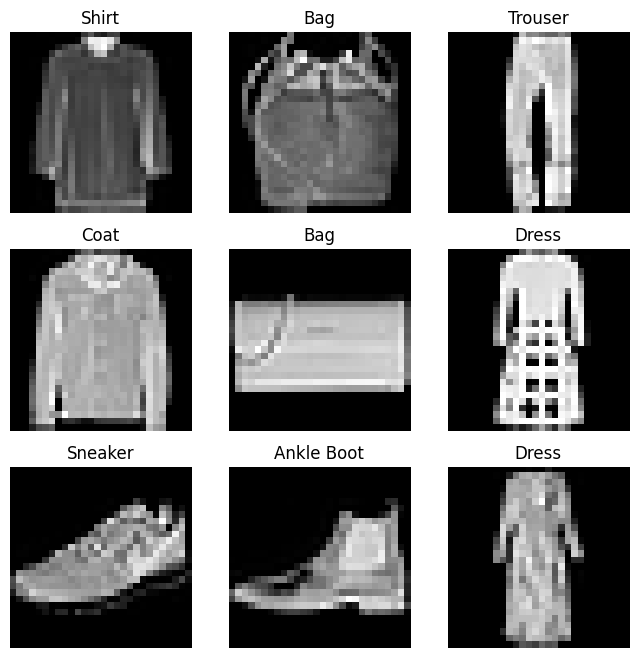

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

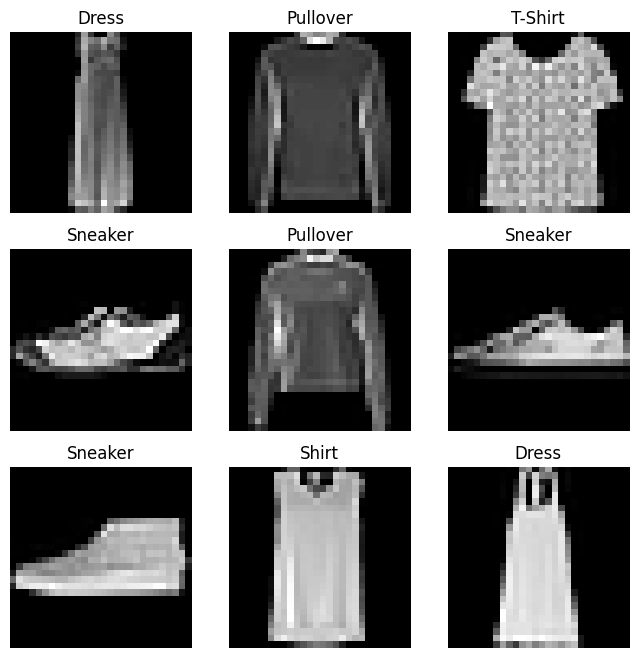

In [ ]:
#Test DataSet
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 0.8943150401115417
Epoch 1, Batch 200, Loss: 0.5856596779823303
Epoch 1, Batch 300, Loss: 0.5302984178066253
Epoch 1, Batch 400, Loss: 0.493035332262516
Epoch 1, Batch 500, Loss: 0.4546979863941669
Epoch 1, Batch 600, Loss: 0.43564113572239876
Epoch 1, Batch 700, Loss: 0.4398683585226536
Epoch 1, Batch 800, Loss: 0.41947924822568894
Epoch 1, Batch 900, Loss: 0.42354237094521524
Epoch 2, Batch 100, Loss: 0.4090692204236984
Epoch 2, Batch 200, Loss: 0.3996918006241322
Epoch 2, Batch 300, Loss: 0.3887489476799965
Epoch 2, Batch 400, Loss: 0.37956555709242823
Epoch 2, Batch 500, Loss: 0.38064905256032944
Epoch 2, Batch 600, Loss: 0.37554051980376246
Epoch 2, Batch 700, Loss: 0.3611651773750782
Epoch 2, Batch 800, Loss: 0.350949135273695
Epoch 2, Batch 900, Loss: 0.36961370199918747
Epoch 3, Batch 100, Loss: 0.3566361239552498
Epoch 3, Batch 200, Loss: 0.3484097756445408
Epoch 3, Batch 300, Loss: 0.34398410230875015
Epoch 3, Batch 400, Loss: 0.34275386452674866
Epo

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.8733%


In [ ]:
# Evaluate the model and store predictions
model.eval()
predictions = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())  # Store predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

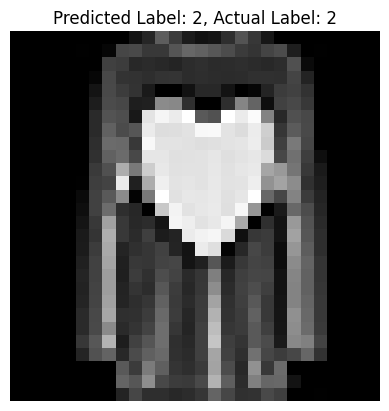

In [ ]:
# Get one test image and its label
image, label = images[1], labels[1]

# Reshape the image tensor to a 28x28 shape
image = image.view(28, 28)

# Convert the image tensor to a numpy array for visualization
image_numpy = image.numpy()

# Show the image
plt.imshow(image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predictions[1]}, Actual Label: {label.item()}')
plt.axis('off')
plt.show()


Step 2. In a new .ipynb notebook, reproduce the results utilizing the "QMNIST" dataset

Step 3. Report on the results in terms of prediction accuracy on the train and test datasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Load Fashion MNIST dataset and preprocess
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.QMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

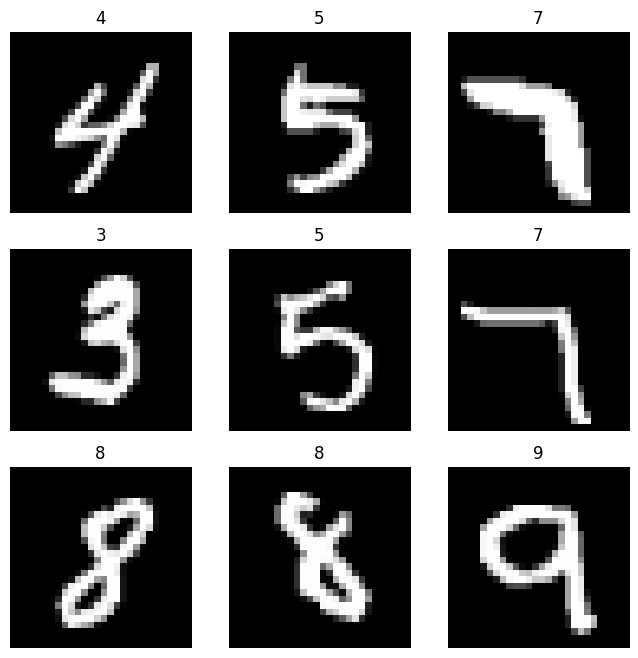

In [ ]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

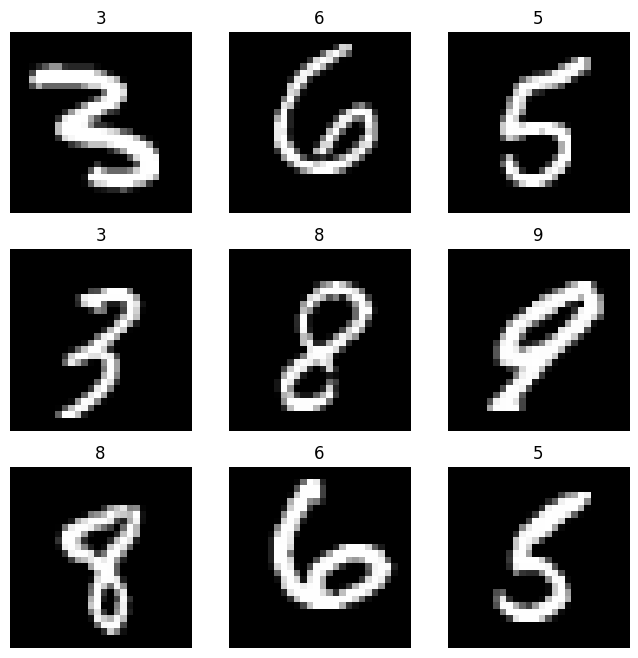

In [ ]:
#Test DataSet
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
#Define the neural network architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLP()

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 1.0463326689600945
Epoch 1, Batch 200, Loss: 0.44061136528849604
Epoch 1, Batch 300, Loss: 0.3803908620774746
Epoch 1, Batch 400, Loss: 0.3392521345615387
Epoch 1, Batch 500, Loss: 0.30830431029200556
Epoch 1, Batch 600, Loss: 0.2742084886133671
Epoch 1, Batch 700, Loss: 0.26205633021891117
Epoch 1, Batch 800, Loss: 0.2480681300908327
Epoch 1, Batch 900, Loss: 0.23367511682212352
Epoch 2, Batch 100, Loss: 0.2196897552534938
Epoch 2, Batch 200, Loss: 0.18543523672968149
Epoch 2, Batch 300, Loss: 0.20291750628501176
Epoch 2, Batch 400, Loss: 0.2022833414375782
Epoch 2, Batch 500, Loss: 0.18310531914234163
Epoch 2, Batch 600, Loss: 0.16536633726209402
Epoch 2, Batch 700, Loss: 0.1703419577330351
Epoch 2, Batch 800, Loss: 0.16683845851570367
Epoch 2, Batch 900, Loss: 0.1541809826437384
Epoch 3, Batch 100, Loss: 0.15295686852186918
Epoch 3, Batch 200, Loss: 0.13655223812907935
Epoch 3, Batch 300, Loss: 0.15059493174776434
Epoch 3, Batch 400, Loss: 0.139203485902398

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set: { correct / total}%')

Accuracy on train set: 0.9750333333333333%


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.9659%


In [ ]:
# Evaluate the model and store predictions
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        predictions = []
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())  # Store predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

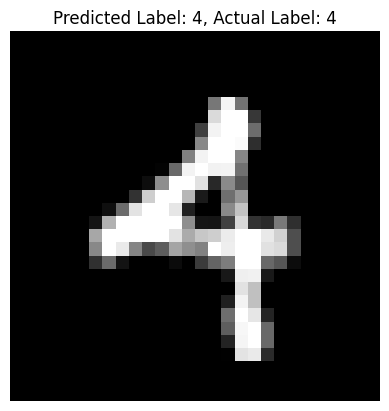

In [ ]:
# Get one test image and its label
image, label = images[5], labels[5]

# Reshape the image tensor to a 28x28 shape
image = image.view(28, 28)

# Convert the image tensor to a numpy array for visualization
image_numpy = image.numpy()

# Show the image
plt.imshow(image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predictions[5]}, Actual Label: {label.item()}')
plt.axis('off')
plt.show()


Step 4. Choose one of the proposed modifications below:

1. Add another Dense layer of 128 nodes
2. Increase the current number of nodes in the layer to 256

Hypothesize how it would change the performance results


We will be adding another dense layer of 128 nodes.

Hypothesis: Since the accuracy is already high, we might see a small increase in the accuracy. But, this might also mean we are overfitting the model by increasing the complexity. We might see a reduction in the test accuracy.

Step 5. Modify the model based on the chosen method and train

In [ ]:
#Define the neural network architecture
class MLPWithDenseLayer(nn.Module):
    def __init__(self):
        super(MLPWithDenseLayer, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fcdense = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fcdense(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLPWithDenseLayer()

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 1.1268374860286712
Epoch 1, Batch 200, Loss: 0.47598993077874185
Epoch 1, Batch 300, Loss: 0.40210871025919914
Epoch 1, Batch 400, Loss: 0.34062313139438627
Epoch 1, Batch 500, Loss: 0.31211542814970017
Epoch 1, Batch 600, Loss: 0.30773200951516627
Epoch 1, Batch 700, Loss: 0.2710860577225685
Epoch 1, Batch 800, Loss: 0.25753173768520354
Epoch 1, Batch 900, Loss: 0.2316029904782772
Epoch 2, Batch 100, Loss: 0.21013165075331927
Epoch 2, Batch 200, Loss: 0.20796217888593674
Epoch 2, Batch 300, Loss: 0.2007505103200674
Epoch 2, Batch 400, Loss: 0.20694965608417987
Epoch 2, Batch 500, Loss: 0.17195567648857832
Epoch 2, Batch 600, Loss: 0.1722345842793584
Epoch 2, Batch 700, Loss: 0.18253512244671583
Epoch 2, Batch 800, Loss: 0.17049340907484292
Epoch 2, Batch 900, Loss: 0.16169440608471633
Epoch 3, Batch 100, Loss: 0.14798347625881433
Epoch 3, Batch 200, Loss: 0.13154206117615103
Epoch 3, Batch 300, Loss: 0.1393149190954864
Epoch 3, Batch 400, Loss: 0.136645309254

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set: { correct / total}%')

Accuracy on train set: 0.97635%


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.9645333333333334%


In [ ]:
# Evaluate the model and store predictions
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        predictions = []
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())  # Store predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

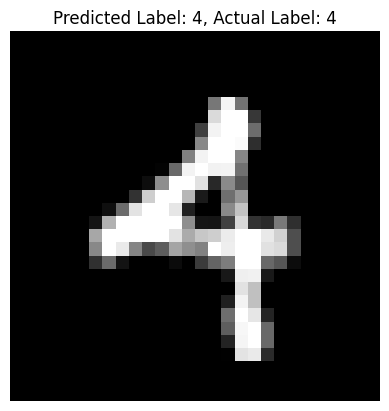

In [ ]:
# Get one test image and its label
image, label = images[5], labels[5]

# Reshape the image tensor to a 28x28 shape
image = image.view(28, 28)

# Convert the image tensor to a numpy array for visualization
image_numpy = image.numpy()

# Show the image
plt.imshow(image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predictions[5]}, Actual Label: {label.item()}')
plt.axis('off')
plt.show()


From the experiment, we see the following accuracy data:

Original Model:
```
Training Accuracy: 0.9750

Testing Accuracy: 0.9659
```
Model with new 128 Dense Layer:
```
Training Accuracy: 0.9763

Testing Accuracy: 0.9645
```
As anticipated, since the model already had an high accuracy, we see a small increase in the training accuracy. But this might also mean that the model is overfitting.

This is validated by the decrease in the test accuracy.


Step 7. Experiment with different optimizers, loss functions, dropout, and activation functions, and observe the change in performance as you tune these hyperparameters.

### Experiment with Optimizer - SGD With Momentum

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 0.06231535483151674
Epoch 1, Batch 200, Loss: 0.056786431563086805
Epoch 1, Batch 300, Loss: 0.05207830374361947
Epoch 1, Batch 400, Loss: 0.05349074364406988
Epoch 1, Batch 500, Loss: 0.04734943171730265
Epoch 1, Batch 600, Loss: 0.051071684821508825
Epoch 1, Batch 700, Loss: 0.05119921502657235
Epoch 1, Batch 800, Loss: 0.04646484459284693
Epoch 1, Batch 900, Loss: 0.044710975422058256
Epoch 2, Batch 100, Loss: 0.04454380614683032
Epoch 2, Batch 200, Loss: 0.04813427176093683
Epoch 2, Batch 300, Loss: 0.04831558954203501
Epoch 2, Batch 400, Loss: 0.04584198391065002
Epoch 2, Batch 500, Loss: 0.04410808756714687
Epoch 2, Batch 600, Loss: 0.04501225106883794
Epoch 2, Batch 700, Loss: 0.04177354902727529
Epoch 2, Batch 800, Loss: 0.047176810035016385
Epoch 2, Batch 900, Loss: 0.039846278617624194
Epoch 3, Batch 100, Loss: 0.05123184077441692
Epoch 3, Batch 200, Loss: 0.03630310000386089
Epoch 3, Batch 300, Loss: 0.042009615378919986
Epoch 3, Batch 400, Loss: 0.

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set: { correct / total}%')

Accuracy on train set: 0.9887833333333333%


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.9736833333333333%


In [ ]:
# Evaluate the model and store predictions
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        predictions = []
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())  # Store predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

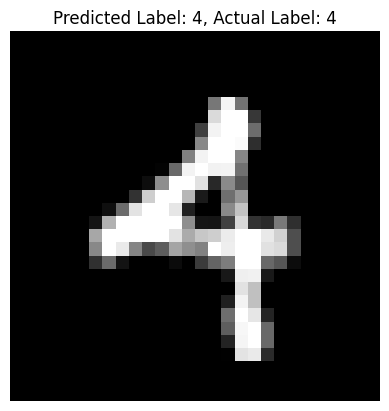

In [ ]:
# Get one test image and its label
image, label = images[5], labels[5]

# Reshape the image tensor to a 28x28 shape
image = image.view(28, 28)

# Convert the image tensor to a numpy array for visualization
image_numpy = image.numpy()

# Show the image
plt.imshow(image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predictions[5]}, Actual Label: {label.item()}')
plt.axis('off')
plt.show()


Model with 128 Dense Layer Adam Optimizer:
```
Training Accuracy: 0.9763

Testing Accuracy: 0.9645
```
Model with 128 Dense Layer SGD with Momentum Optimizer:
```
Training Accuracy: 0.9887

Testing Accuracy: 0.9736
```
We see that with the use of SGD with Momentum Optimizer, we are seeing an increase in the accuracy of the model.

### Experiment with Activation Function: SELU instead of Relu

In [ ]:
#Define the neural network architecture
class MLPWithDenseLayerSELU(nn.Module):
    def __init__(self):
        super(MLPWithDenseLayerSELU, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fcdense = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.selu(self.fc1(x))
        x = torch.selu(self.fcdense(x))
        x = torch.selu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLPWithDenseLayerSELU()

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 0.8012640964984894
Epoch 1, Batch 200, Loss: 0.4047159872949123
Epoch 1, Batch 300, Loss: 0.32450674861669543
Epoch 1, Batch 400, Loss: 0.2834457851201296
Epoch 1, Batch 500, Loss: 0.2844776754081249
Epoch 1, Batch 600, Loss: 0.24365442410111426
Epoch 1, Batch 700, Loss: 0.23552637379616498
Epoch 1, Batch 800, Loss: 0.22935047291219235
Epoch 1, Batch 900, Loss: 0.2083524824678898
Epoch 2, Batch 100, Loss: 0.1581713822670281
Epoch 2, Batch 200, Loss: 0.16168912090361118
Epoch 2, Batch 300, Loss: 0.1584966378286481
Epoch 2, Batch 400, Loss: 0.15967461835592986
Epoch 2, Batch 500, Loss: 0.15470255613327027
Epoch 2, Batch 600, Loss: 0.1609830473922193
Epoch 2, Batch 700, Loss: 0.1374961094930768
Epoch 2, Batch 800, Loss: 0.13460240000858903
Epoch 2, Batch 900, Loss: 0.13613263120874763
Epoch 3, Batch 100, Loss: 0.11531796135008335
Epoch 3, Batch 200, Loss: 0.11955878688953817
Epoch 3, Batch 300, Loss: 0.11648499346338212
Epoch 3, Batch 400, Loss: 0.133433222193270

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set: { correct / total}%')

Accuracy on train set: 0.9778333333333333%


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.9669%


In [ ]:
# Evaluate the model and store predictions
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        predictions = []
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())  # Store predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

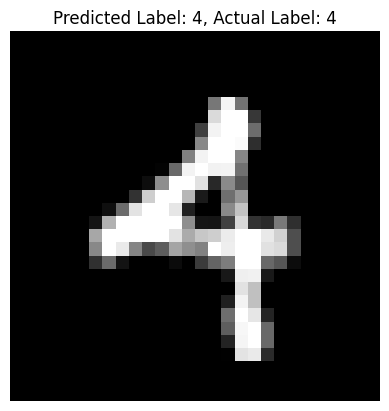

In [ ]:
# Get one test image and its label
image, label = images[5], labels[5]

# Reshape the image tensor to a 28x28 shape
image = image.view(28, 28)

# Convert the image tensor to a numpy array for visualization
image_numpy = image.numpy()

# Show the image
plt.imshow(image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predictions[5]}, Actual Label: {label.item()}')
plt.axis('off')
plt.show()


Model with Dense Layer and RELU Activation Function:
```
Training Accuracy: 0.9763

Testing Accuracy: 0.9645
```
Model with Dense Layer and SELU Activation Function:
```
Training Accuracy: 0.9778

Testing Accuracy: 0.9669
```
We see that with the use of SELU as an activation function, we see a marginal increase in the accuracy.

## Experiment With Dropout Layer:

In [ ]:
class MLPWithDenseLayerDropout(nn.Module):
    def __init__(self):
        super(MLPWithDenseLayerDropout, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fcdense = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fcdense(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

# Initialize the neural network
model = MLPWithDenseLayerDropout()


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 2.0162443351745605
Epoch 1, Batch 200, Loss: 1.2440818709135055
Epoch 1, Batch 300, Loss: 0.960828909277916
Epoch 1, Batch 400, Loss: 0.8158374887704849
Epoch 1, Batch 500, Loss: 0.7940958619117737
Epoch 1, Batch 600, Loss: 0.7323667702078819
Epoch 1, Batch 700, Loss: 0.6849939864873886
Epoch 1, Batch 800, Loss: 0.6619203734397888
Epoch 1, Batch 900, Loss: 0.6464994651079178
Epoch 2, Batch 100, Loss: 0.5998415717482567
Epoch 2, Batch 200, Loss: 0.5998544725775719
Epoch 2, Batch 300, Loss: 0.5849167017638683
Epoch 2, Batch 400, Loss: 0.5949629062414169
Epoch 2, Batch 500, Loss: 0.5813657510280609
Epoch 2, Batch 600, Loss: 0.5727172850072384
Epoch 2, Batch 700, Loss: 0.5563858476281166
Epoch 2, Batch 800, Loss: 0.5644820520281791
Epoch 2, Batch 900, Loss: 0.5310518604516983
Epoch 3, Batch 100, Loss: 0.5258419458568097
Epoch 3, Batch 200, Loss: 0.5134566861391068
Epoch 3, Batch 300, Loss: 0.511759357303381
Epoch 3, Batch 400, Loss: 0.5265497356653214
Epoch 3, Bat

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on train set: { correct / total}%')

Accuracy on train set: 0.9304%


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}%')

Accuracy on test set: 0.9271166666666667%


In [ ]:
# Evaluate the model and store predictions
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        predictions = []
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())  # Store predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

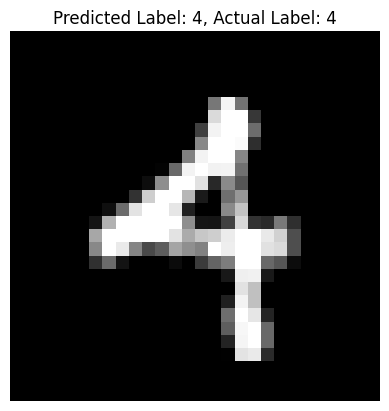

In [ ]:
# Get one test image and its label
image, label = images[5], labels[5]

# Reshape the image tensor to a 28x28 shape
image = image.view(28, 28)

# Convert the image tensor to a numpy array for visualization
image_numpy = image.numpy()

# Show the image
plt.imshow(image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predictions[5]}, Actual Label: {label.item()}')
plt.axis('off')
plt.show()


Model with Dense Layer without Dropout Layers:
```
Training Accuracy: 0.9763

Testing Accuracy: 0.9645
```
Model with Dense Layer with Dropout Layers:
```
Training Accuracy: 0.9304

Testing Accuracy: 0.9271
```
We see that with the use of dropout layers led to decrease in the training and testing accuracy. Dropout helps in reducing overfitting. However, in this case, it made the model simplier and thus, a reduction in accuracy.